In [ ]:
import sys
from pathlib import Path


try:
    current_path = Path(__file__).resolve().parent
except NameError:
    current_path = Path.cwd()

parent_path = str(current_path.parent)

if parent_path not in sys.path:
    sys.path.append(parent_path)

In [7]:
import matplotlib.pyplot as plt
import torch

def visualize_attention(model, device, test_loader):
    model.eval()
    
    # 1. 데이터 가져오기
    data, target = next(iter(test_loader))
    img = data[0].unsqueeze(0).to(device)
    
    with torch.no_grad():
        # 임베딩 통과
        x = model.embedding(img)
        # 첫 번째 레이어 통과 (x와 attn_weights를 반환한다고 가정)
        # 만약 ViTModule이 x만 반환한다면, 내부의 mha를 직접 호출해야 할 수도 있습니다.
        x, attn_weights = model.layers[0](x) 

    # 2. 에러 발생 지점 수정
    # attn_weights의 shape이 [1, 17, 17]인 경우:
    if attn_weights.dim() == 3:
        # [Batch=0, CLS_token_row=0, Patch_columns=1:]
        cls_attn = attn_weights[0, 0, 1:] 
    else:
        # 혹시라도 4차원으로 들어올 경우 (heads 포함)
        cls_attn = attn_weights[0, :, 0, 1:].mean(dim=0)

    # 3. 4x4 그리드로 재구성
    # patch_size=7이면 28/7 = 4이므로 4x4가 맞습니다.
    attn_heatmap = cls_attn.reshape(4, 4).cpu().numpy()
    
    # 4. 시각화
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img.cpu().squeeze(), cmap='gray')
    axes[0].set_title(f"Original (Label: {target[0]})")
    
    axes[1].imshow(img.cpu().squeeze(), cmap='gray')
    # 어텐션 맵을 원본 크기에 맞게 확장하여 겹침
    im = axes[1].imshow(attn_heatmap, cmap='jet', alpha=0.6, extent=(0, 28, 28, 0))
    axes[1].set_title("Attention Heatmap")
    
    plt.colorbar(im, ax=axes[1])
    plt.show()




In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os


def mnist_dataloader():

    batch_size: int = 64

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    data_path = os.path.join("..","datasets", "mnist")
    train_dataset = datasets.MNIST(
        root=data_path, train=True, transform=transform, download=True
    )
    test_dataset = datasets.MNIST(root=data_path, train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [9]:
from vision.vit_model import ViTEncoder

import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = mnist_dataloader()
model_path = os.path.join('..','vit_mnist_model.pth')
patch_size: int = 7
embedding_batch_size: int = patch_size * patch_size
epochs = 10
learning_rate = 0.001

model = ViTEncoder(
    img_size=28,
    patch_size=patch_size,
    embedding_size=embedding_batch_size,
    num_class=10,
    num_heads=7,
).to(device=device)

if os.path.exists(model_path):
    # 가중치를 불러와서 모델에 입힘
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    # 5. 추론 모드 전환 (Dropout, LayerNorm 등을 평가 모드로 고정)
    model.eval()
    print(f"성공적으로 모델 가중치를 '{model_path}'에서 불러왔습니다.")
else:
    print(f"에러: '{model_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")

성공적으로 모델 가중치를 '..\vit_mnist_model.pth'에서 불러왔습니다.


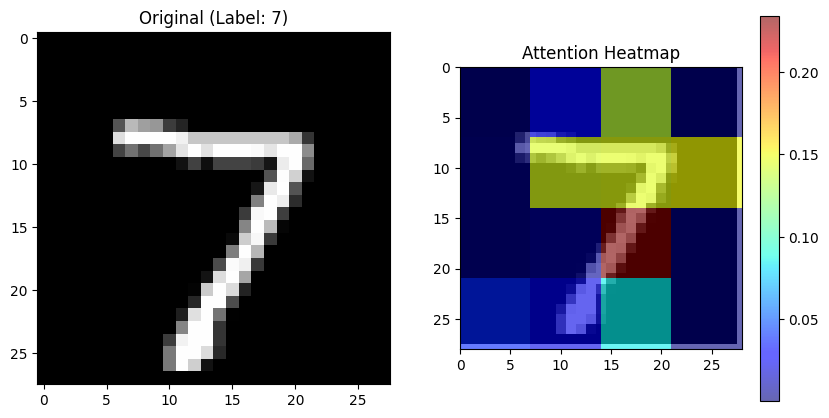

In [10]:

# 실행
visualize_attention(model, device, test_loader)